## Check the performance of Models

In [1]:
import torch
import torch.nn as nn
import Datasets
import utils
import time
from ConvEncoder import ConvEncoder
from ConvDecoder import ConvDecoder
from Conv3DRNNCell import Conv3DGRUCell
from RNNEncoder import RNNEncoder
from RNNDecoder import RNNDecoder
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,5)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


### Load Models

In [3]:
conv_encoder = ConvEncoder(input_channels=1)
conv_encoder.to(device)
conv_encoder.load_state_dict(torch.load('/home/agajan/DeepMRI/models/final_conv_encoder'))
conv_encoder.eval()

conv_decoder = ConvDecoder(out_channels=1)
conv_decoder.to(device)
conv_decoder.load_state_dict(torch.load('/home/agajan/DeepMRI/models/final_conv_decoder'))
conv_decoder.eval()

rnn_encoder = RNNEncoder(
    Conv3DGRUCell,
    input_channels=64,
    hidden_channels=128,
    kernel_size=3,
    stride=1,
    padding=1,
    hidden_kernel_size=3
)
rnn_encoder.to(device)
rnn_encoder.load_state_dict(torch.load('/home/agajan/DeepMRI/models/final_adam_rnn_encoder_401'))
rnn_encoder.eval()

rnn_decoder = RNNDecoder(
    Conv3DGRUCell,
    input_channels=64,
    hidden_channels=128,
    kernel_size=3,
    stride=1,
    padding=1,
    hidden_kernel_size=3,
    output_channels=64,
    output_kernel_size=3
)
rnn_decoder.load_state_dict(torch.load('/home/agajan/DeepMRI/models/final_adam_rnn_decoder_401'))
rnn_decoder.to(device)
rnn_decoder.eval()

RNNDecoder(
  (rnn): Conv3DGRUCell(
    (conv_input): Conv3d(192, 384, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (conv_hidden): Conv3d(128, 384, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (out_conv): Conv3d(320, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

### Get one 4D fMRI image

In [4]:
fmri_path = '/home/agajan/data/sfnwmrda7339173_session_1_rest_1.nii.gz'
# fmri_path = '/home/agajan/test_data/sfnwmrda9744150_session_1_rest_1.nii.gz'
seq_len = 230
fmri = nib.load(fmri_path).get_fdata()[:, :, :, :seq_len] # take first 50 sequences
print(fmri.shape)

(49, 58, 47, 230)


How to get feature representation of 4D series?
1. For each 3D volume use ConvEncoder to encode into series of 3D features.
2. Use RNNEncoder to encode series of 3D features.

### Get 3D representations

In [5]:
with torch.no_grad():
    conv_enc_out = torch.zeros(fmri.shape[3], 64, 7, 8, 6)
    for i in range(fmri.shape[3]):
        slice_3d = torch.tensor(fmri[:, :, :, i]).unsqueeze(0).unsqueeze(0).float()# batch x channel x w x h x d
        feature = conv_encoder(slice_3d.to(device)).cpu().squeeze()
        conv_enc_out[i, :, :, :, :] = feature

In [6]:
# series of 3D feature representations
conv_enc_out.shape # time x channel x w x h x d

torch.Size([230, 64, 7, 8, 6])

### Get representation from 3D representations

In [7]:
with torch.no_grad():
    context_batch = rnn_encoder(conv_enc_out.unsqueeze(0).to(device))
print(context_batch.shape)

torch.Size([1, 128, 7, 8, 6])


How to decode feature into original 3D series?
1. Use RNNDecoder to decode feature into series of 3D features.
2. For each 3D feature use ConvDecoder to get original volume.

### Get back 3D representations

In [8]:
with torch.no_grad():
    trg_batch = conv_enc_out.unsqueeze(0).to(device)
    seq_len = trg_batch.shape[1]

    hidden_batch = context_batch

    input_batch = trg_batch.new_ones(trg_batch[:, 0, :, :, :, :].shape)

    rnn_outputs = trg_batch.new_zeros(trg_batch.shape)

    for t in range(seq_len):
        input_batch, hidden_batch = rnn_decoder(input_batch, hidden_batch, context_batch)
        rnn_outputs[:, t, :, :, :, :] = input_batch

    print(rnn_outputs.shape)

torch.Size([1, 230, 64, 7, 8, 6])


### Decode 3D features

In [9]:
out_fmri = torch.zeros(fmri.shape)

In [10]:
with torch.no_grad():
    for i in range(seq_len):
        out_3d = conv_decoder(rnn_outputs[:,i,:,:,:,:])
        out_fmri[:,:,:,i] = out_3d.cpu()

In [11]:
out_fmri.shape

torch.Size([49, 58, 47, 230])

### (Optional) Decode back for comparison

In [12]:
conv_dec_out = torch.zeros(fmri.shape)
with torch.no_grad():
    for i in range(seq_len):
        out_3d = conv_decoder(conv_enc_out[i].unsqueeze(0).to(device)).squeeze()
        conv_dec_out[:,:,:,i] = out_3d.cpu()

### Plot slices

In [13]:
w = 24
h = 29
d = 23
t = 0

#### Original Image

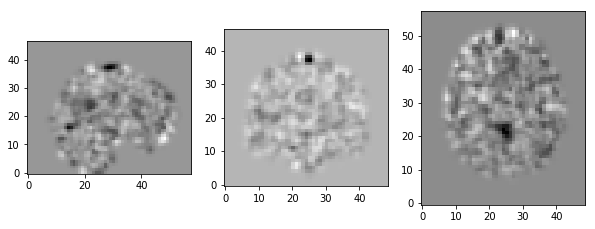

In [14]:
utils.show_slices([
    fmri[w, :, :, t],
    fmri[:, h, :, t],
    fmri[:, :, d, t]
], figsize=(10, 20))

#### After ConvDecoder

torch.Size([49, 58, 47, 230])


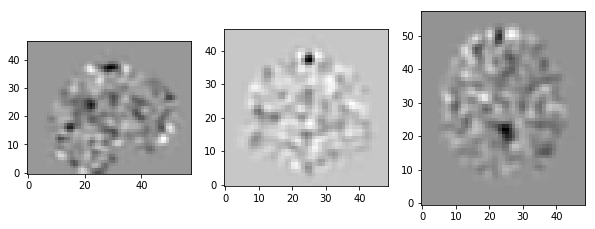

In [15]:
print(conv_dec_out.shape)

utils.show_slices([
    conv_dec_out.detach().squeeze().cpu().numpy()[w, :, :, t],
    conv_dec_out.detach().squeeze().cpu().numpy()[:, h, :, t],
    conv_dec_out.detach().squeeze().cpu().numpy()[:, :, d, t]
])

#### After RNNDecoder + ConvDecoder

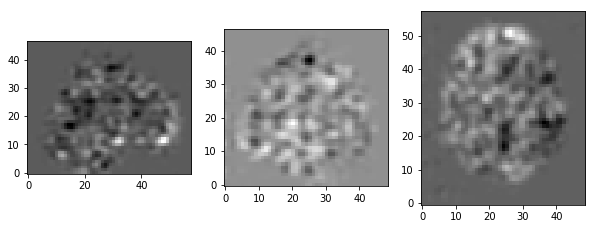

In [16]:
utils.show_slices([
    out_fmri.detach().cpu().numpy()[w, :, :, t],
    out_fmri.detach().cpu().numpy()[:, h, :, t],
    out_fmri.detach().cpu().numpy()[:, :, d, t]
])

In [17]:
criterion = nn.MSELoss()
loss_conv = criterion(conv_dec_out.cpu(), torch.tensor(fmri).float())
loss_rnn_conv = criterion(out_fmri.cpu(), torch.tensor(fmri).float())
print("Loss_conv: {}, Loss_rnn_conv: {}".format(loss_conv, loss_rnn_conv))

Loss_conv: 0.5033204555511475, Loss_rnn_conv: 2.105264186859131
